# Prediction for Diabetes in Adult Females of Pima Indian Heritage

## 1. Introduction:

In the medical industry, the ability to efficiently and effectively detect and remedy diseases is crucial to improving a patient's health. Quite notably, the early detection of diabetes, a chronic metabolic disorder affecting millions worldwide, can prevent serious complications. Luckily, with advancements in data science we can create models to help predict whether a person has diabetes or not by employing the methods of classification. 

We hope to answer the question: Can we determine key identifiers to whether an adult female of Pima Indian heritage has diabetes, and whether using these specific identifiers produces a better model for prediction of diabetes in an adult female of Pima Indian heritage than using all the given predictors?

Using an existing data set from The National Institute of Diabetes and Digestive and Kidney Diseases, we will create a classification model to determine the answer to our question. All patients listed in this database are females over the age of 21 and of Pima Indian heritage. This data set consists of several medical predictors (independent) variables and one target (dependent) variable, Outcome. They have modeled the outcome on two class variables 0 (does not have diabetes) and 1 (has diabetes).


In [59]:
### run to install necessary libraries ###
library(repr)
library(tidyverse)
library(tidymodels)
install.packages("kknn")
install.packages("janitor")
library(janitor)
options(repr.matrix.max.rows = 6)

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



## 2. Preliminary exploratory data analysis:

First, the foundation for building a good classification prediction model is to load the correct libraries and read the data using the read_csv() function.

In [60]:
# read the data
diabetes <- read_csv("https://raw.githubusercontent.com/asnbl/dsci-100-2023-24W-group-16/main/diabetes.csv")

diabetes

Rows: 768 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): Pregnancies, Glucose, BloodPressure, SkinThickness, Insulin, BMI, D...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
6,148,72,35,0,33.6,0.627,50,1
1,85,66,29,0,26.6,0.351,31,0
8,183,64,0,0,23.3,0.672,32,1
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
5,121,72,23,112,26.2,0.245,30,0
1,126,60,0,0,30.1,0.349,47,1
1,93,70,31,0,30.4,0.315,23,0


**Table 1 : Original Diabetes Data Set**

Looking at the original data, there was not a lot that had to be done to tidy the data. However, to make the data easier for the average consumer to interpret, we decided to rename 'Outcome' to 'Diabetes' and refactor its values as "yes" and "no", rather than 1 and 0. After that, we then replaced all 0 values which are not in pregnancies with NA as those 0 values are representative of a lack of a measurement (e.g. you cannot have a skin thickness of 0)

In [65]:
# tidy and wrangle data
diabetes_clean <- diabetes |>
    clean_names() |>
    mutate(outcome = as_factor(outcome)) |>
    rename("diabetes" = outcome) |> 
    mutate(diabetes = fct_recode(diabetes, "yes" = "1", "no"  = "0")) |>
    mutate(across(.cols = -pregnancies, ~replace(., . == 0, NA)))

head(diabetes_clean)

pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
6,148,72,35,NA,33.6,0.627,50,yes
1,85,66,29,NA,26.6,0.351,31,no
8,183,64,NA,NA,23.3,0.672,32,yes
1,89,66,23,94,28.1,0.167,21,no
0,137,40,35,168,43.1,2.288,33,yes
5,116,74,NA,NA,25.6,0.201,30,no


**Table 2 : Cleaned Diabetes Data Set**

Now we split the data into training and testing sets. 

In [93]:
set.seed(1000)

diabetes_split <- initial_split(diabetes_clean, prop = 0.75, strata = diabetes)
diabetes_train <- training(diabetes_split)
diabetes_test <- testing(diabetes_split) 

diabetes_train
diabetes_test

pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
1,85,66,29,NA,26.6,0.351,31,no
1,89,66,23,94,28.1,0.167,21,no
5,116,74,NA,NA,25.6,0.201,30,no
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
1,128,88,39,110,36.5,1.057,37,yes
6,190,92,NA,NA,35.5,0.278,66,yes
1,126,60,NA,NA,30.1,0.349,47,yes


pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age,diabetes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
0,137,40,35,168,43.1,2.288,33,yes
10,168,74,NA,NA,38.0,0.537,34,yes
7,107,74,NA,NA,29.6,0.254,31,yes
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
0,123,72,NA,NA,36.3,0.258,52,yes
9,170,74,31,NA,44.0,0.403,43,yes
5,121,72,23,112,26.2,0.245,30,no


### Summarizing the Data

Here, we will summarize properties of our training data, like the proportion of people with diabetes vs no diabetes, means of predictors, and amount of NA values.

In [67]:
# summary
diabetes_proportions <- diabetes_train |>
    group_by(diabetes) |>
    summarize(count = n()) |>
    mutate(percent = 100*count/nrow(diabetes_train))

diabetes_proportions

diabetes,count,percent
<fct>,<int>,<dbl>
no,375,65.10417
yes,201,34.89583


**Table 3 : Diabetes Proportions**

From the data frame above, we can see that around 65% of our training data does not have diabetes, and around 35% does. As the class with no presence of diabetes represents the majority of the training data, the majority classifier will always predict that a new observation has diabetes. Hopefully we will create a model with a greater accuracy than that of the majority classifier (in this case ~65%).

In [78]:
missing_count <- sum(is.na(diabetes_train))
missing_count

[1] 483

This number represents how many missing values are in our training data set.

Now to get the mean values for each column, first we must remove the NA values.

In [79]:
predictor_means <- diabetes_train |>
    na.omit() |>
    select(-diabetes) |>
    map_df(mean)

predictor_means

pregnancies,glucose,blood_pressure,skin_thickness,insulin,bmi,diabetes_pedigree_function,age
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3.299003,123.6047,70.88704,29.14618,162.4319,33.17708,0.5153355,30.79734


**Table 4 : Mean of the Predictors**

In the above data frame, the average value for each predictor is displayed. 

### Visualizing the Data

It is important to use summary tables and visualizations to analyze distributions between groups. Here, we will use box plots to look at relationship between the predictor variable and the response variable to do feature selection and narrow down the number of predictor variables we want to use.

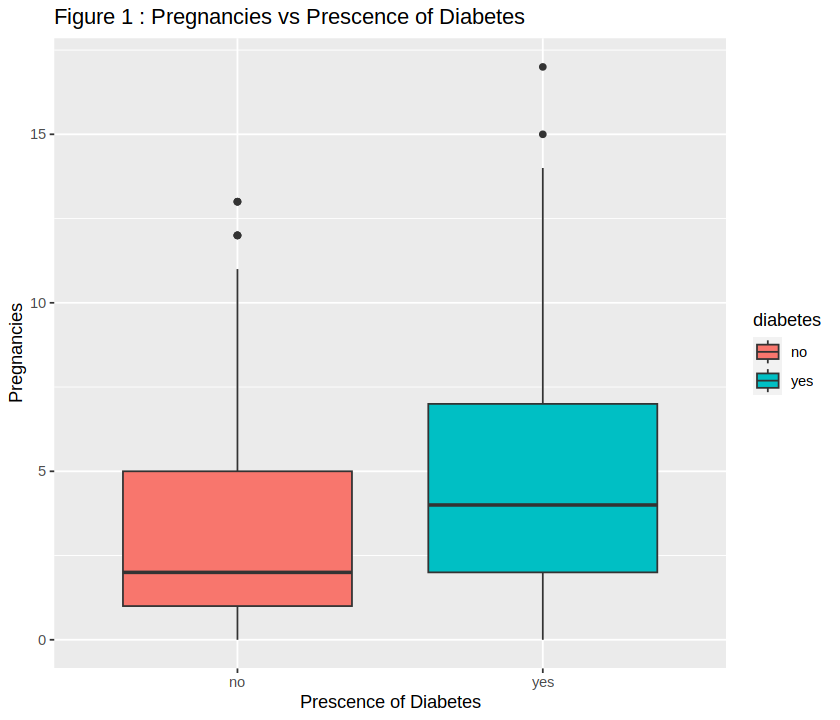

In [80]:
# Set options for plot width and height
options(repr.plot.width = 7, repr.plot.height = 6)

pregnancies <- ggplot(diabetes_train, aes(x = diabetes, y = pregnancies, fill = diabetes)) +
        geom_boxplot() +
        labs( x = "Prescence of Diabetes", y = "Pregnancies") +
        ggtitle("Figure 1 : Pregnancies vs Prescence of Diabetes")

pregnancies

The plot is a box plot comparing the number of pregnancies between individuals with and without diabetes, indicating a higher median number of pregnancies in individuals with diabetes.

Warning message:
“Removed 2 rows containing non-finite values (`stat_boxplot()`).”


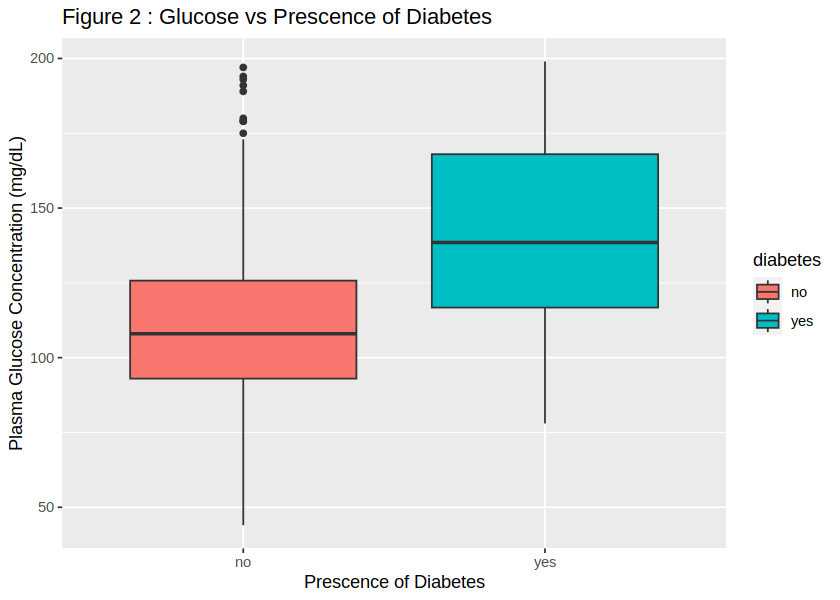

In [81]:
# Set options for plot width and height
options(repr.plot.width = 7, repr.plot.height = 5)

glucose <- ggplot(diabetes_train, aes(x = diabetes, y = glucose, fill = diabetes)) +
        geom_boxplot() +
        labs( x = "Prescence of Diabetes", y = "Plasma Glucose Concentration (mg/dL)") +
        ggtitle("Figure 2 : Glucose vs Prescence of Diabetes")
glucose

The plot is a box plot displaying the distribution of plasma glucose concentrations, showing higher levels in individuals with diabetes compared to those without.

Warning message:
“Removed 27 rows containing non-finite values (`stat_boxplot()`).”


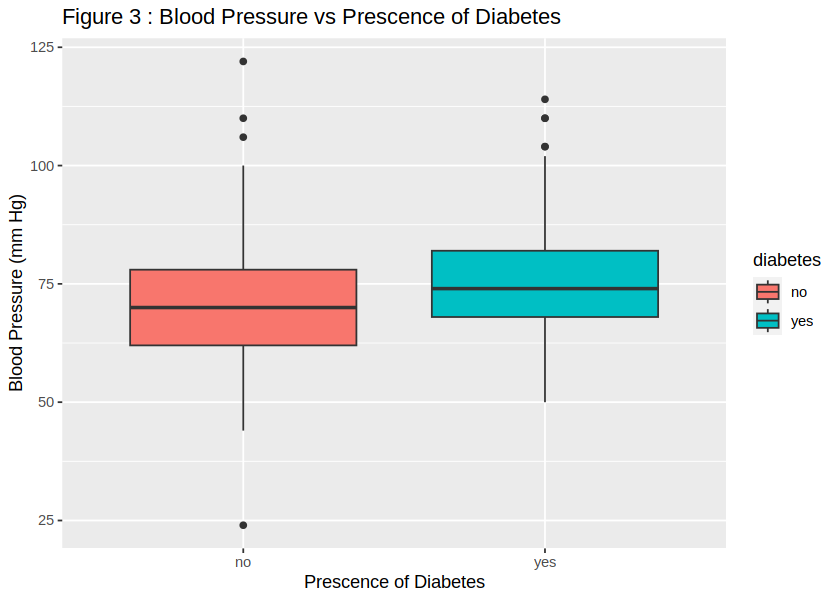

In [82]:
# Set options for plot width and height
options(repr.plot.width = 7, repr.plot.height = 5)

blood_pressure <- ggplot(diabetes_train, aes(x = diabetes, y = blood_pressure, fill = diabetes)) +
        geom_boxplot() +
        labs( x = "Prescence of Diabetes", y = "Blood Pressure (mm Hg)") +
        ggtitle("Figure 3 : Blood Pressure vs Prescence of Diabetes")
blood_pressure

The plot is a box plot showing blood pressure distribution with generally higher values in individuals diagnosed with diabetes compared to those without diabetes.

Warning message:
“Removed 171 rows containing non-finite values (`stat_boxplot()`).”


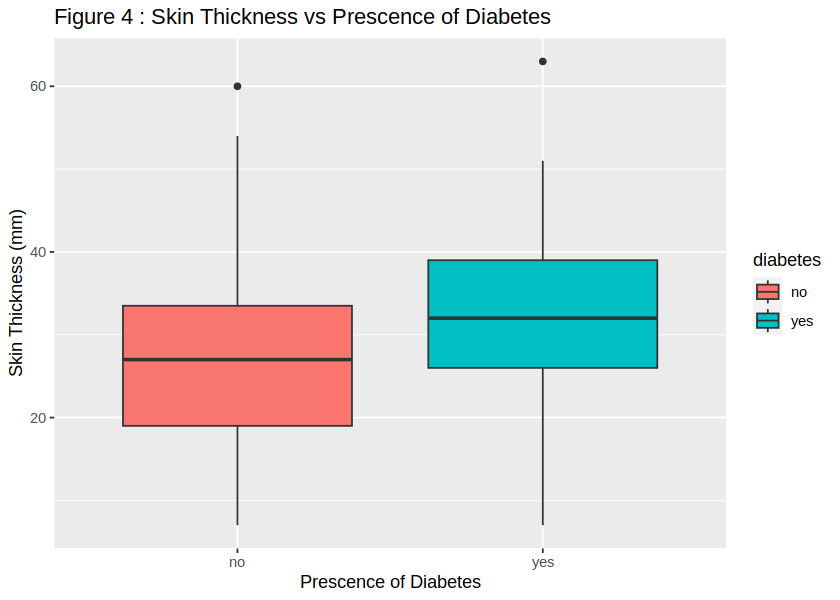

In [83]:
# Set options for plot width and height
options(repr.plot.width = 7, repr.plot.height = 5)

skin_thickness <- ggplot(diabetes_train, aes(x = diabetes, y = skin_thickness, fill = diabetes)) +
        geom_boxplot() +
        labs( x = "Prescence of Diabetes", y = "Skin Thickness (mm)") +
        ggtitle("Figure 4 : Skin Thickness vs Prescence of Diabetes")
skin_thickness

The plot is a box plot comparing skin thickness measurements, showing a slightly higher median skin thickness in individuals with diabetes compared to those without.

Warning message:
“Removed 275 rows containing non-finite values (`stat_boxplot()`).”


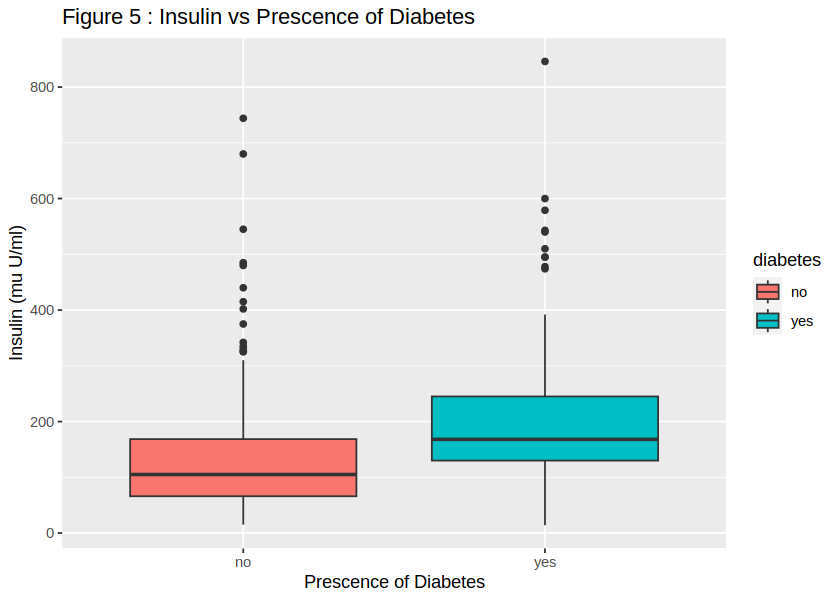

In [84]:
# Set options for plot width and height
options(repr.plot.width = 7, repr.plot.height = 5)

insulin <- ggplot(diabetes_train, aes(x = diabetes, y = insulin, fill = diabetes)) +
        geom_boxplot() +
        labs( x = "Prescence of Diabetes", y = "Insulin (mu U/ml)") +
        ggtitle("Figure 5 : Insulin vs Prescence of Diabetes")
insulin

The plot is a box plot showing that individuals with diabetes have a wider range and higher median insulin levels compared to those without diabetes.

Warning message:
“Removed 8 rows containing non-finite values (`stat_boxplot()`).”


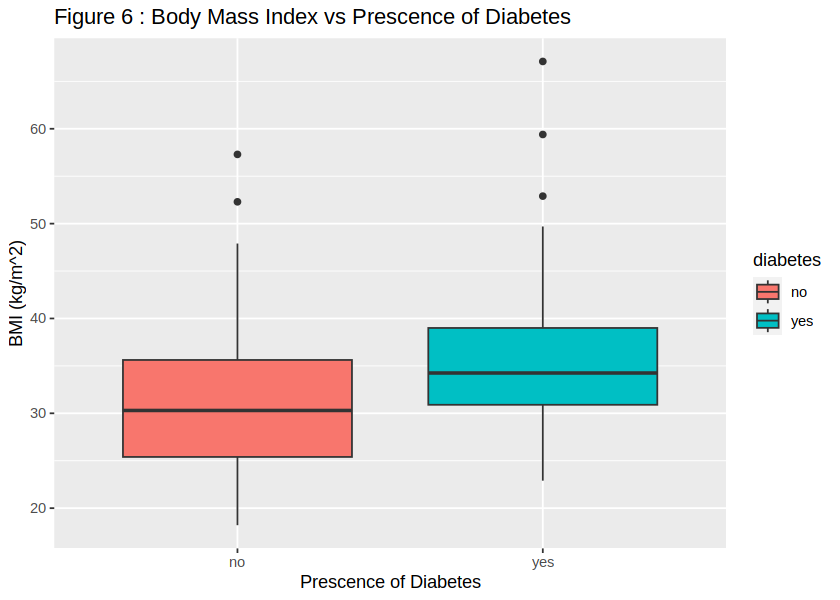

In [85]:
# Set options for plot width and height
options(repr.plot.width = 7, repr.plot.height = 5)

BMI <- ggplot(diabetes_train, aes(x = diabetes, y = bmi, fill = diabetes)) +
        geom_boxplot() + 
        labs( x = "Prescence of Diabetes", y = "BMI (kg/m^2)") +
        ggtitle("Figure 6 : Body Mass Index vs Prescence of Diabetes")
BMI

The plot is a box plot illustrating that individuals with diabetes tend to have higher Body Mass Index (BMI) values than those without diabetes.

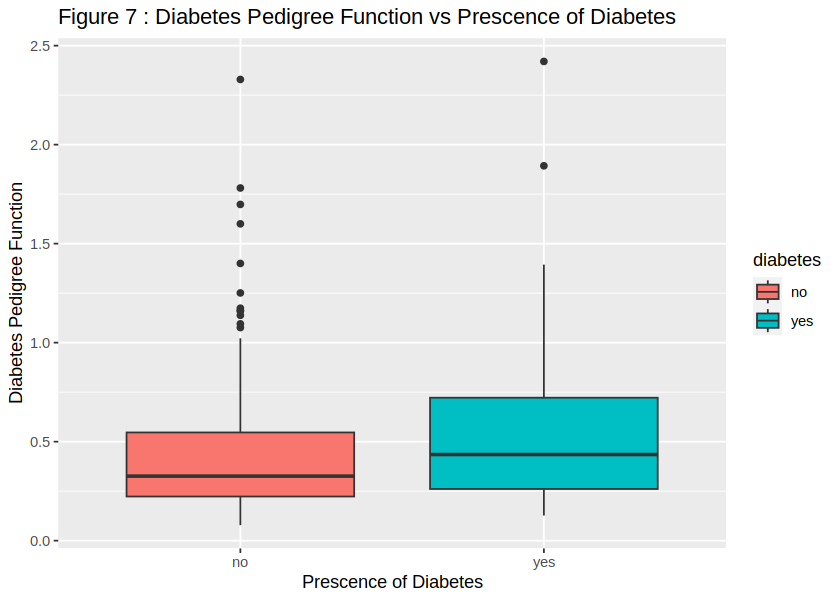

In [86]:
# Set options for plot width and height
options(repr.plot.width = 7, repr.plot.height = 5)

diabetes_pedigree_fn <- ggplot(diabetes_train, 
                               aes(x = diabetes, y = diabetes_pedigree_function, fill = diabetes)) +
        geom_boxplot() + 
        labs( x = "Prescence of Diabetes", y = "Diabetes Pedigree Function") +
        ggtitle("Figure 7 : Diabetes Pedigree Function vs Prescence of Diabetes")
diabetes_pedigree_fn

The plot is a box plot showing that the values of the Diabetes Pedigree Function are higher on average for individuals with diabetes than for those without.

From the above graphs, it can be seen that the predictors with the least overlap between the boxes for each of the two response variables are glucose and insulin. This means a model using glucose and insulin as predictors will most likely produce the best results. Using these specific predictors we will make a knn classification model and then compare it with a knn classification model made using all the given predictors.

### Overall Conclusion

To limit the amount of observations lost, we make a new set of training data with the NA values removed after selecting the necessary columns.

In [97]:
# Using only glucose and insulin
# Set the seed
set.seed(1000)

dia1_train <- diabetes_train |>
            select(glucose, insulin, diabetes) |>
            na.omit()

dia1_test <- diabetes_test |>
            select(glucose, insulin, diabetes) |>
            na.omit()

dim(dia1_train)
dim(dia1_test)

[1] 298   3

[1] 95  3

## Making the Model(s)
For each knn classification model, we first combined pre-processing and model training using a workflow. Then by tuning and using cross-validation, we determined the optimal k-value to use for our classifier.

### Using only Glucose and Insulin

Warning message:
“Removed 2 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 2 rows containing missing values (`geom_line()`).”


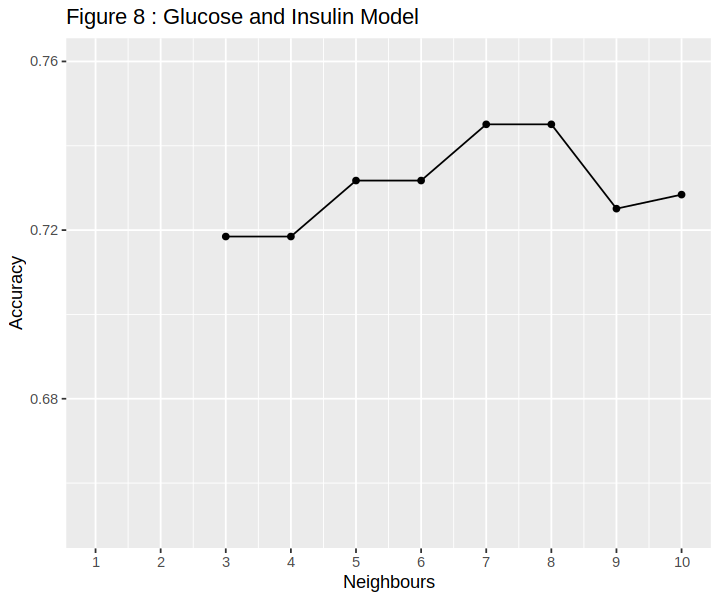

In [100]:
# Set the seed
set.seed(1000) 

options(repr.plot.height = 5, repr.plot.width = 6)

k_vals <- tibble(neighbors = seq(from = 1, to = 10))

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
            set_engine("kknn") |>
            set_mode("classification")

dia1_recipe <- recipe(diabetes ~., data = dia1_train) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors())

dia1_vfold <- vfold_cv(dia1_train, v = 5, strata = diabetes)


dia1_results <- workflow() |>
            add_recipe(dia1_recipe) |>
            add_model(knn_spec) |>
            tune_grid(resamples = dia1_vfold, grid = k_vals) |>
            collect_metrics() 

cross_val_plot <- filter(dia1_results, .metric == "accuracy") |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbours", y = "Accuracy") +
    scale_x_continuous(breaks = seq(0, 20)) +
    scale_y_continuous(limits = c(0.65, 0.76)) +
    ggtitle("Figure 8 : Glucose and Insulin Model")

cross_val_plot

From this it can be seen that the optimal k-value appears to be either 7 or 8. For our model, we will choose 7 as we have 2 classes, and therefore using an odd number will remove the possibility of a tie.

Now, we can create the model and test it's accuracy on the test data that the classifier was not trained on and compare results.

In [104]:
# Using only glucose and insulin
# Set the seed
set.seed(1000) 

dia1_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 7) |>
            set_engine("kknn") |>
            set_mode("classification")

dia1_fit <- workflow() |>
            add_recipe(dia1_recipe) |>
            add_model(dia1_spec) |>
            fit(data = dia1_train) 

dia1_predictions <- predict(dia1_fit, dia1_test) |>
                    bind_cols(dia1_test)

dia1_metrics <- dia1_predictions |> metrics(truth = diabetes, estimate = .pred_class) |>
                filter(.metric == "accuracy")

dia1_conf_mat <- dia1_predictions |>
                 conf_mat(truth = diabetes, estimate = .pred_class) 

dia1_predictions
dia1_metrics
dia1_conf_mat

.pred_class,glucose,insulin,diabetes
<fct>,<dbl>,<dbl>,<fct>
no,137,168,yes
no,126,235,no
yes,143,146,yes
⋮,⋮,⋮,⋮
no,126,120,no
no,81,57,no
no,121,112,no


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.7157895


          Truth
Prediction no yes
       no  57  16
       yes 11  11

**Table 5 : Predictions using Glucose and Insulin**

Here, we can see that the model trained on just insulin and glucose as predictors has an accuracy estimate of 71.6%.
It can also be observed that the classifier predicted a higher amount of yes classes predicted incorrectly as no which is corroborates with the original distribution of yes and no classes we had in the training data (65% no, 35% yes).

### Visualization

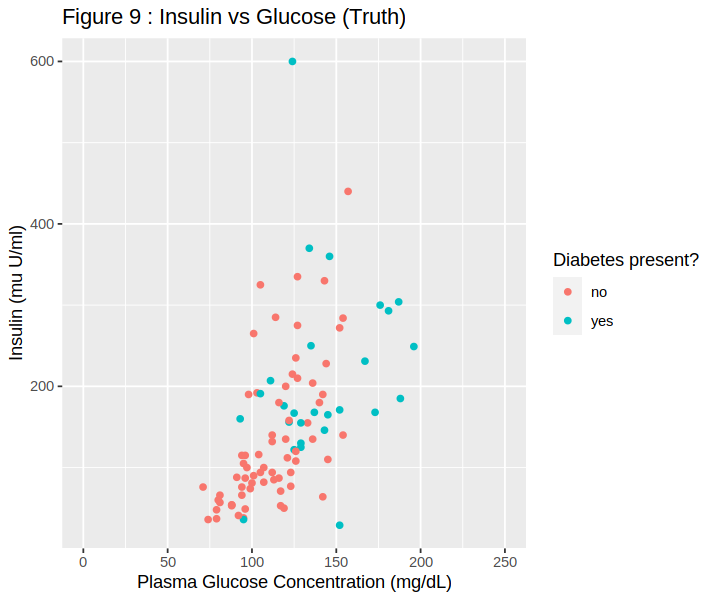

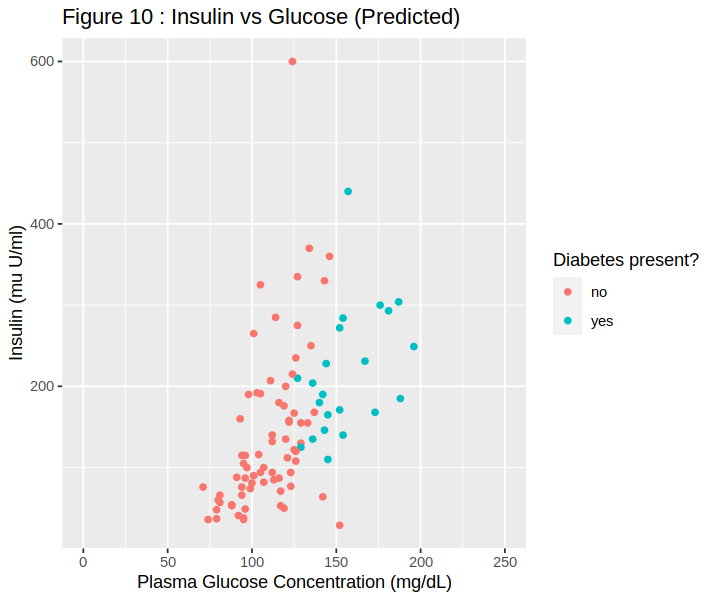

In [105]:
# Graph of Insulin and Glucose

dia1_truth_graph <- ggplot(dia1_predictions, aes(x = glucose, y = insulin, color = diabetes)) +
        geom_point() +
        labs(x = "Plasma Glucose Concentration (mg/dL)", y = "Insulin (mu U/ml)", color = "Diabetes present?") +
        ggtitle("Figure 9 : Insulin vs Glucose (Truth)") +
        scale_x_continuous(limits = c(0, 250))

dia1_pred_graph <- ggplot(dia1_predictions, aes(x = glucose, y = insulin, color = .pred_class)) +
        geom_point() +
        labs(x = "Plasma Glucose Concentration (mg/dL)", y = "Insulin (mu U/ml)", color = "Diabetes present?") +
        ggtitle("Figure 10 : Insulin vs Glucose (Predicted)") +
        scale_x_continuous(limits = c(0, 250)) 

dia1_truth_graph
dia1_pred_graph

Above is a visualization of the actual class distribution (Figure 9) and the model's predictions (Figure 10). We can see that the generally, the points appear to be correct, although there are definitely some issues with accuracy in the predicted where the distribution of the two actual classes have heavy overlap.

### Using all Given Predictors

We remove the NA values from the original training and testing data to ensure there are no issues with the execution of the vfold function.

In [112]:
# Using all predictors
# Set the seed
set.seed(500) 

dia2_train <- na.omit(diabetes_train)

dia2_test <- na.omit(diabetes_test)

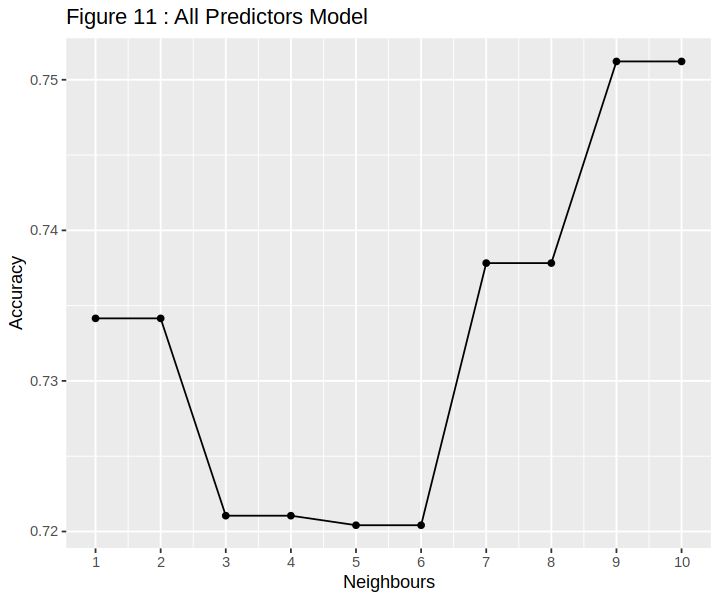

In [113]:
# Set the seed
set.seed(1000) 

options(repr.plot.height = 5, repr.plot.width = 6)

dia2_recipe <- recipe(diabetes ~., data = dia2_train) |>
            step_scale(all_predictors()) |>
            step_center(all_predictors())

dia2_vfold <- vfold_cv(dia2_train, v = 5, strata = diabetes)


dia2_results <- workflow() |>
            add_recipe(dia2_recipe) |>
            add_model(knn_spec) |>
            tune_grid(resamples = dia2_vfold, grid = k_vals) |>
            collect_metrics() 

cross_val_plot <- filter(dia2_results, .metric == "accuracy") |>
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbours", y = "Accuracy") +
    scale_x_continuous(breaks = seq(0, 20)) +
    ggtitle("Figure 11 : All Predictors Model")

cross_val_plot

From this it can be seen that the optimal k-value appears to be either 5 or 6 again. For our model, we will choose 5 as we have 2 classes, and therefore using an odd number will remove the possibility of a tie.

In [114]:
# Using all predictors
# Set the seed
set.seed(1000) 

dia2_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 9) |>
            set_engine("kknn") |>
            set_mode("classification")

dia2_fit <- workflow() |>
            add_recipe(dia2_recipe) |>
            add_model(dia2_spec) |>
            fit(data = dia2_train) 

dia2_predictions <- predict(dia2_fit, dia2_test) |>
                    bind_cols(dia2_test)

dia2_metrics <- dia2_predictions |> metrics(truth = diabetes, estimate = .pred_class) |>
                filter(.metric == "accuracy")

dia2_conf_mat <- dia2_predictions |>
                 conf_mat(truth = diabetes, estimate = .pred_class) 
dia2_metrics
dia2_conf_mat

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8105263


          Truth
Prediction no yes
       no  59   9
       yes  9  18

**Table 6 : Predictions using all the predictors**

As we can see, the model produces less accurate results when using all the predictors to train the model, with the accuracy being 68.9% compared to the earlier 73.7%.

We did not create a visualization for this one as there are too many predictors to graph.

## Discussion

### Summary of the results found:

In this project we were indeed able to determine key identifiers to whether an adult female of Pima Indian heritage has diabetes using box plots. Then, after building the models and evaluating their performances, we found that the model trained with glucose and insulin gave an accuracy of 73.7% while the model trained with all the predictors gave an accuracy of 70.9%. Thus, it can be said that we were able to produce a better classification model for prediction of diabetes in an adult female of Pima Indian heritage when trained on just the key identifiers(Glucose and Insulin) rather than all of the possible predictors. 

### Expected results:

The results that we found were the same as what we expected to find. As glucose and insulin were the two predictors that produced box plots of which had the least overlap when plotted against presence of diabetes, we came to a conclusion that a model using glucose and insulin as predictors will most likely produce the best results. This was then verified by our evaluation of both models. 

### Impacts:

A model like this can not only contribute to the growing field of predictive medicine but also enhance the concept of preventive healthcare practices which can help improve the lives of millions who are susceptible to diabetes. Timely intervention and adjustments to their lifestyle can aid in managing the condition and lowering the disease's risk. Although our model is not extremely accurate, it is a good start to helping identify individuals at high risk. If a sufficient model is made, we can then examine the efficiency of various intervention approaches, such as dietary and exercise programs, to determine which ones are the most effective in preventing diabetes.

### Future Questions:
To conclude, while we were able to produce a model which predicts the presence of diabetes in an adult female of Pima Indian heritage, it is not the most accurate, with the better model having an accuracy of **SMT**. Thus, we can ask: "how we can better our model?". There are many potential reasons for the inaccuracies in our model, one of which being the uneven distribution of those with and without diabetes in our original data set(65% without, 35% with). A future question that can be asked would be "Can upsampling help improve the accuracy of our model?" or "Will a differently proportioned data set yield the same results?".


## References

Learning, U. M. (2016, October 6). Pima Indians Diabetes Database. Kaggle. https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database 

Keen, H., & Jarrett, R. J. (1971). Diabetes mellitus in Pima indians. Lancet (London, England), 2(7720), 379–380. https://doi.org/10.1016/s0140-6736(71)90098-5

Bennett, P. H., Rushforth, N. B., Miller, M., &amp; Lecompte, P. M. (1976). Epidemiologic studies of diabetes in the Pima Indians. Proceedings of the 1975 Laurentian Hormone Conference, Volume 32, 333–371. https://doi.org/10.1016/b978-0-12-571132-6.50021-x 

